GLIDE
====

**GLIDE: Towards Photorealistic Image Generation and Editing with Text-Guided Diffusion Models**

 * Paper: https://arxiv.org/abs/2112.10741
 * Code: https://github.com/openai/glide-text2im

![GLIDE Examples](../assets/glide_examples.jpg)


```bash
conda create -n glide python=3.11 -y
conda activate glide
pip install git+https://github.com/openai/glide-text2im
pip install pyyaml
pip install matplotlib
```

## text-to-image

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import torch

from glide_text2im.download import load_checkpoint
from glide_text2im.model_creation import (
    create_model_and_diffusion,
    model_and_diffusion_defaults,
    model_and_diffusion_defaults_upsampler
)

/home/pyml/anaconda3/envs/glide/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
has_cuda = torch.cuda.is_available()
base_steps = "100"  # number of diffusion steps to use for sampling
upsample_steps = "fast27"  # number of diffusion steps to use for upsampling
device = torch.device("cuda" if has_cuda else "cpu")

# Create base model.
options = model_and_diffusion_defaults()
options['use_fp16'] = has_cuda
options['timestep_respacing'] = str(base_steps)

model, diffusion = create_model_and_diffusion(**options)
model.eval()
if has_cuda:
    model.convert_to_fp16()
model.to(device)
model.load_state_dict(load_checkpoint('base', device))
print(' * total base parameters', sum(x.numel() for x in model.parameters()))



# Create upsampler model.
options_up = model_and_diffusion_defaults_upsampler()
options_up['use_fp16'] = has_cuda
options_up['timestep_respacing'] = upsample_steps
model_up, diffusion_up = create_model_and_diffusion(**options_up)
model_up.eval()
if has_cuda:
    model_up.convert_to_fp16()
model_up.to(device)
model_up.load_state_dict(load_checkpoint('upsample', device))
print(' * total upsampler parameters', sum(x.numel() for x in model_up.parameters()))


 * total base parameters 385030726
 * total upsampler parameters 398361286


### Helper function: Sample from base

In [3]:
##############################
# Sample from the base model #
##############################
 
def sample_base(prompt, batch_size=1, guidance_scale=3.0):
    # Create the text tokens to feed to the model.
    tokens = model.tokenizer.encode(prompt)
    tokens, mask = model.tokenizer.padded_tokens_and_mask(
        tokens, options['text_ctx']
    )

    # Create the classifier-free guidance tokens (empty)
    full_batch_size = batch_size * 2
    uncond_tokens, uncond_mask = model.tokenizer.padded_tokens_and_mask(
        [], options['text_ctx']
    )

    # Pack the tokens together into model kwargs.
    model_kwargs = dict(
        tokens=torch.tensor(
            [tokens] * batch_size + [uncond_tokens] * batch_size, device=device
        ),
        mask=torch.tensor(
            [mask] * batch_size + [uncond_mask] * batch_size,
            dtype=torch.bool,
            device=device,
        ),
    )

    # Create a classifier-free guidance sampling function
    def model_fn(x_t, ts, **kwargs):
        half = x_t[: len(x_t) // 2]
        combined = torch.cat([half, half], dim=0)
        model_out = model(combined, ts, **kwargs)
        eps, rest = model_out[:, :3], model_out[:, 3:]
        cond_eps, uncond_eps = torch.split(eps, len(eps) // 2, dim=0)
        half_eps = uncond_eps + guidance_scale * (cond_eps - uncond_eps)
        eps = torch.cat([half_eps, half_eps], dim=0)
        return torch.cat([eps, rest], dim=1)

    # Sample from the base model.
    model.del_cache()
    samples = diffusion.p_sample_loop(
        model_fn,
        (full_batch_size, 3, options["image_size"], options["image_size"]),
        device=device,
        clip_denoised=True,
        progress=True,
        model_kwargs=model_kwargs,
        cond_fn=None,
    )[:batch_size]
    model.del_cache()

    return samples

### Helper function: Upsample

In [4]:
##############################
# Upsample the 64x64 samples #
##############################

def upsample(samples, prompt, batch_size=1, upsample_temp=0.997):
    tokens = model_up.tokenizer.encode(prompt)
    tokens, mask = model_up.tokenizer.padded_tokens_and_mask(
        tokens, options_up['text_ctx']
    )

    # Create the model conditioning dict.
    model_kwargs = dict(
        # Low-res image to upsample.
        low_res=((samples+1)*127.5).round()/127.5 - 1,

        # Text tokens
        tokens=torch.tensor(
            [tokens] * batch_size, device=device
        ),
        mask=torch.tensor(
            [mask] * batch_size,
            dtype=torch.bool,
            device=device,
        ),
    )

    # Sample from the base model.
    model_up.del_cache()
    up_shape = (batch_size, 3, options_up["image_size"], options_up["image_size"])
    up_samples = diffusion_up.ddim_sample_loop(
        model_up,
        up_shape,
        noise=torch.randn(up_shape, device=device) * upsample_temp,
        device=device,
        clip_denoised=True,
        progress=True,
        model_kwargs=model_kwargs,
        cond_fn=None,
    )[:batch_size]
    model_up.del_cache()

    return up_samples

### Inference

100%|██████████| 100/100 [00:02<00:00, 34.02it/s]

Base samples shape: torch.Size([1, 3, 64, 64])


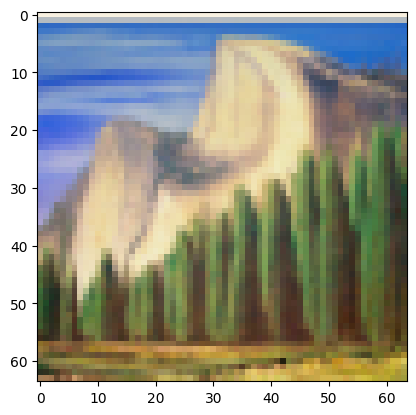

In [5]:
# Sampling parameters
prompt = "a Bob Ross style of painting of a Yosemite landscape with the Half-dome"
batch_size = 1
guidance_scale = 3.0

# Tune this parameter to control the sharpness of 256x256 images.
# A value of 1.0 is sharper, but sometimes results in grainy artifacts.
upsample_temp = 0.997

samples =  sample_base(prompt, batch_size, guidance_scale)

print("Base samples shape:", samples.shape)
image = Image.fromarray(
    ((samples[0].permute(1, 2, 0).cpu().numpy() + 1) * 127.5).round().astype('uint8')
)
plt.imshow(image)

100%|██████████| 27/27 [00:01<00:00, 18.47it/s]


Upsampled samples shape: torch.Size([1, 3, 256, 256])


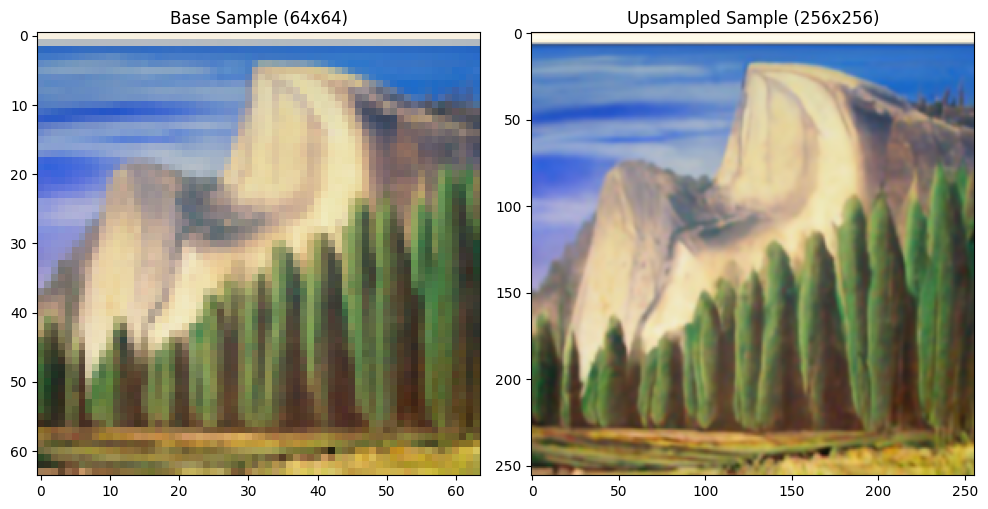

In [8]:
# upsample the 64x64 samples to 256x256
upsampled_samples = upsample(samples, prompt, batch_size, upsample_temp)
print("Upsampled samples shape:", upsampled_samples.shape)

image_up = Image.fromarray(
    ((upsampled_samples[0].permute(1, 2, 0).cpu().numpy() + 1) * 127.5).round().astype('uint8')
)

fig, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=100)
ax[0].imshow(image)
ax[0].set_title("Base Sample (64x64)")
ax[1].imshow(image_up)
ax[1].set_title("Upsampled Sample (256x256)")
plt.tight_layout()
plt.show()
